In [78]:

%matplotlib inline
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [79]:
columns = ['user', 'activity', 'timestamp', 'x-axis', 'y-axis', 'z-axis']
df_har = pd.read_csv('HAR_using_CNN/WISDM_ar_v1.1_raw1.txt', header=None, names=columns,on_bad_lines='skip')




In [80]:
# removing null values
df_har = df_har.dropna()
df_har.shape
# transforming the z-axis to float
df_har['z-axis'] = df_har['z-axis'].str.replace(';', '')
df_har['z-axis'] = df_har['z-axis'].apply(lambda x:float(x))
# drop rows where timestamp is 0
df = df_har[df_har['timestamp'] != 0]
# arrange data in ascending order of user and timestamp
df = df.sort_values(by = ['user', 'timestamp'], ignore_index=True)
print(df.shape) 
print(df.head())

(1073630, 6)
   user activity      timestamp  x-axis  y-axis  z-axis
0     1  Walking  4991922345000    0.69   10.80   -2.03
1     1  Walking  4991972333000    6.85    7.44   -0.50
2     1  Walking  4992022351000    0.93    5.63   -0.50
3     1  Walking  4992072339000   -2.11    5.01   -0.69
4     1  Walking  4992122358000   -4.59    4.29   -1.95


In [7]:
#EDA

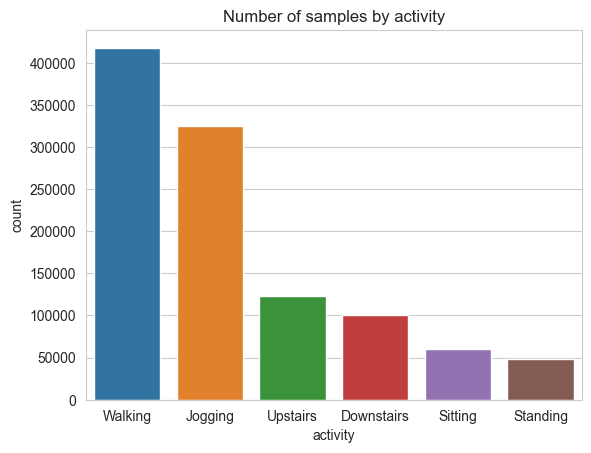

In [84]:
sns.set_style('whitegrid')
sns.countplot(x='activity', data=df)

plt.title('Number of samples by activity')
plt.show()

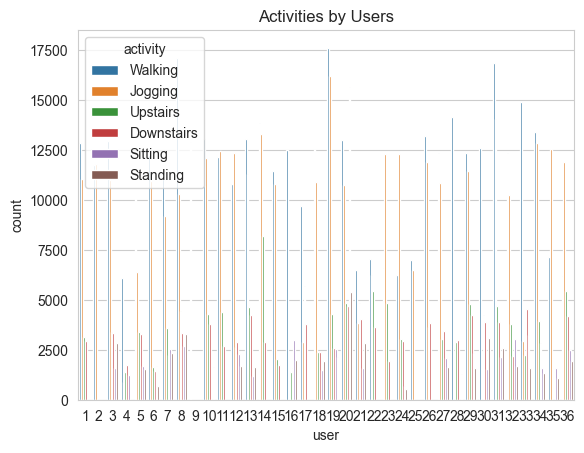

In [86]:
sns.countplot(x = 'user',  hue = 'activity', data = df)
plt.title('Activities by Users')
plt.show()

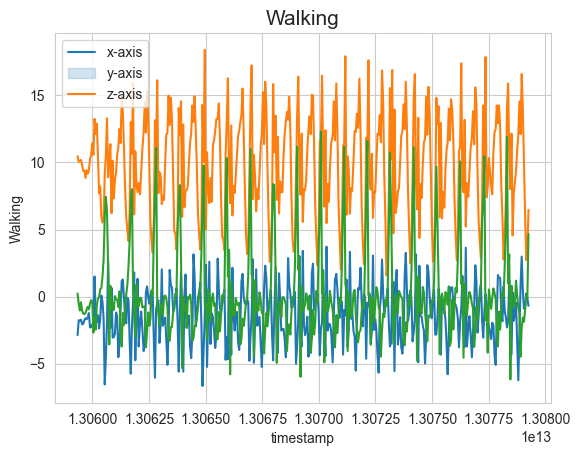

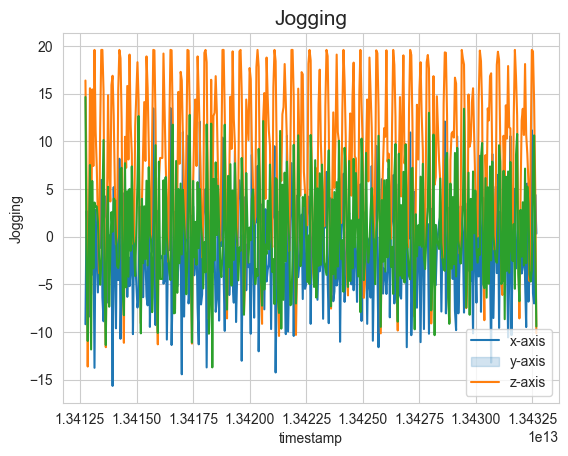

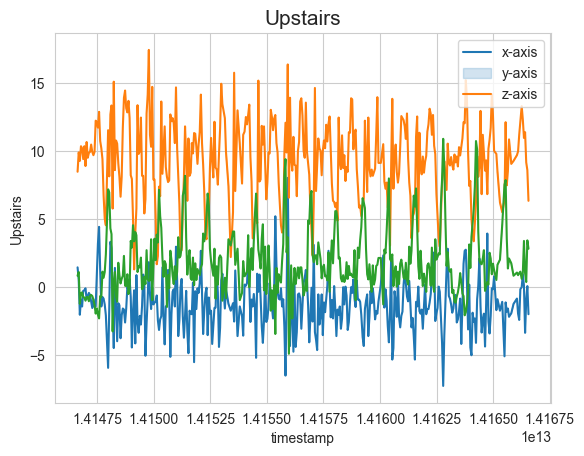

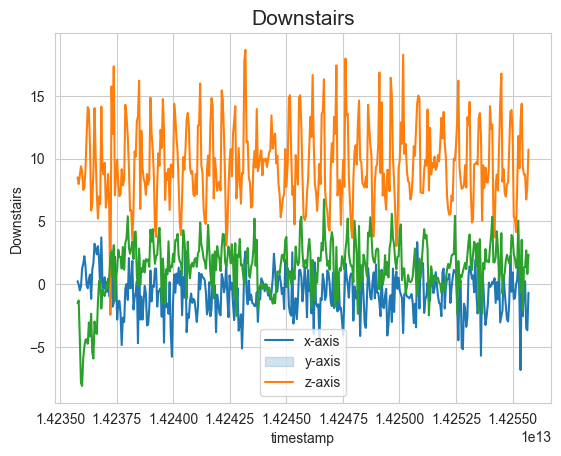

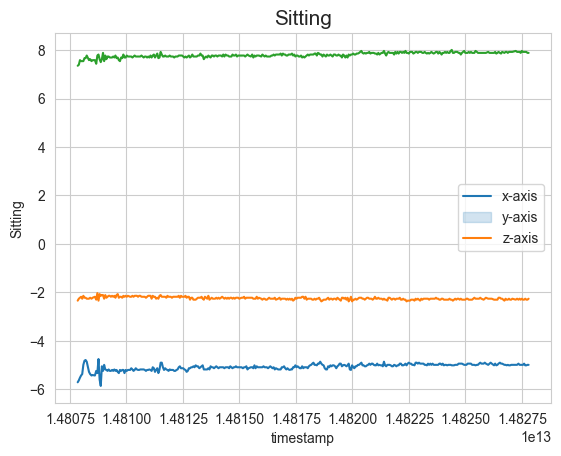

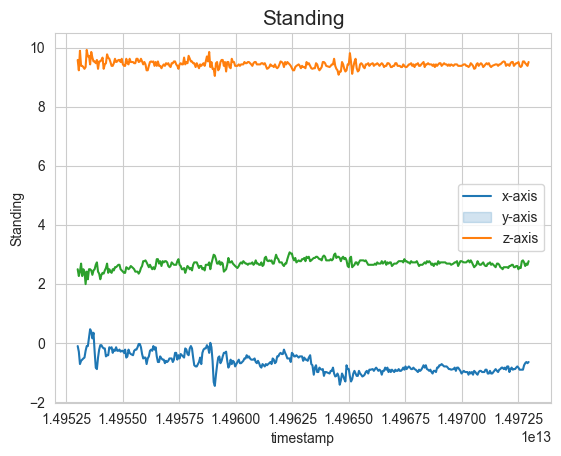

In [90]:
activities = ['Walking', 'Jogging', 'Upstairs', 'Downstairs', 'Sitting', 'Standing']
for i in activities:
    data36 = df[(df['user'] == 36) & (df['activity'] == i)][:400]
    sns.lineplot(y = 'x-axis', x = 'timestamp', data = data36)
    sns.lineplot(y = 'y-axis', x = 'timestamp', data = data36)
    sns.lineplot(y = 'z-axis', x = 'timestamp', data = data36)
    plt.legend(['x-axis', 'y-axis', 'z-axis'])
    plt.ylabel(i)
    plt.title(i, fontsize = 15)
    plt.show()

In [11]:
#data preperation

In [145]:
from scipy import stats
import numpy as np
import pandas as pd
random_seed = 42   
n_time_steps = 50 
n_features = 3 
step = 10 
n_classes = 6 
n_epochs = 50       
batch_size = 1024   
learning_rate = 0.0025
l2_loss = 0.0015
segments = []
labels = []

for i in range(0, df.shape[0] - n_time_steps, step):
    xs = df['x-axis'].values[i: i + 50]
    ys = df['y-axis'].values[i: i + 50]
    zs = df['z-axis'].values[i: i + 50]

    # Using np.unique for label assignment
    label = np.unique(df['activity'][i: i + 50])[0]

    segments.append([xs, ys, zs])
    labels.append(label)

# Reshape segments to a list
reshaped_segments = np.asarray(segments, dtype=np.float32).reshape(-1, n_time_steps, n_features)

# One-hot encode labels
labels = np.asarray(pd.get_dummies(labels), dtype=np.float32)




In [146]:
reshaped_segments.shape

(107358, 50, 3)

In [147]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(reshaped_segments, labels, test_size = 0.2, random_state = random_seed)

In [148]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Flatten, Dropout
model = Sequential()
# RNN layer
model.add(LSTM(units = 128, input_shape = (X_train.shape[1], X_train.shape[2])))
# Dropout layer
model.add(Dropout(0.5)) 
# Dense layer with ReLu
model.add(Dense(units = 64, activation='relu'))
# Softmax layer
model.add(Dense(y_train.shape[1], activation = 'softmax'))
# Compile model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


In [149]:
history = model.fit(X_train, y_train, epochs = n_epochs, validation_split = 0.20, batch_size = batch_size, verbose = 1)

Epoch 1/50


68/68 [==============================] - 26s 333ms/step - loss: 0.9416 - accuracy: 0.6709 - val_loss: 0.5728 - val_accuracy: 0.8017
Epoch 2/50
68/68 [==============================] - 24s 359ms/step - loss: 0.5349 - accuracy: 0.8140 - val_loss: 0.4767 - val_accuracy: 0.8285
Epoch 3/50
68/68 [==============================] - 24s 356ms/step - loss: 0.4689 - accuracy: 0.8325 - val_loss: 0.4572 - val_accuracy: 0.8340
Epoch 4/50
68/68 [==============================] - 41s 604ms/step - loss: 0.4224 - accuracy: 0.8457 - val_loss: 0.5644 - val_accuracy: 0.8223
Epoch 5/50
68/68 [==============================] - 51s 745ms/step - loss: 0.4207 - accuracy: 0.8481 - val_loss: 0.3750 - val_accuracy: 0.8596
Epoch 6/50
68/68 [==============================] - 50s 736ms/step - loss: 0.3562 - accuracy: 0.8688 - val_loss: 0.3747 - val_accuracy: 0.8610
Epoch 7/50
68/68 [==============================] - 50s 737ms/step - loss: 0.3340 - accuracy: 0.8763 - val_loss: 0.3015 - val_accuracy: 0.88

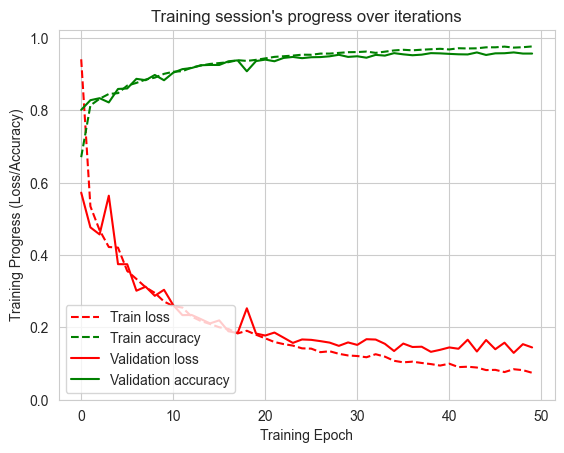

In [150]:
plt.plot(np.array(history.history['loss']), "r--", label = "Train loss")
plt.plot(np.array(history.history['accuracy']), "g--", label = "Train accuracy")
plt.plot(np.array(history.history['val_loss']), "r-", label = "Validation loss")
plt.plot(np.array(history.history['val_accuracy']), "g-", label = "Validation accuracy")
plt.title("Training session's progress over iterations")
plt.legend(loc='lower left')
plt.ylabel('Training Progress (Loss/Accuracy)')
plt.xlabel('Training Epoch')
plt.ylim(0) 
plt.show()

In [151]:
loss, accuracy = model.evaluate(X_test, y_test, batch_size = batch_size, verbose = 1)
print("Test Accuracy :", accuracy)
print("Test Loss :", loss)

21/21 [==============================] - 4s 177ms/step - loss: 0.1427 - accuracy: 0.9587
Test Accuracy : 0.9587369561195374
Test Loss : 0.14274971187114716


In [20]:
#confusion matrix

671/671 [==============================] - 6s 9ms/step


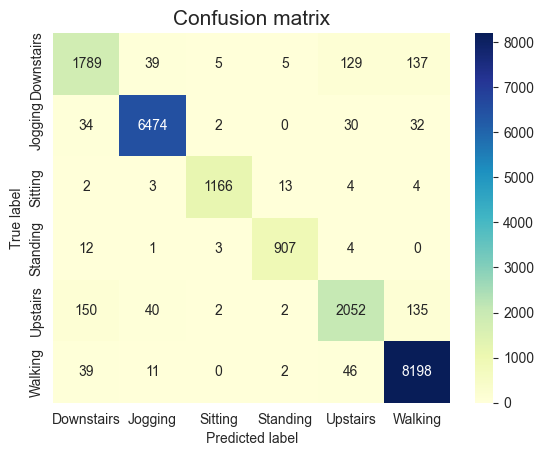

In [154]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import metrics  # Import the metrics module

# Assuming you have class labels defined somewhere
class_labels = ['Downstairs', 'Jogging', 'Sitting', 'Standing', 'Upstairs', 'Walking']

# Assuming you have predictions and true labels defined somewhere
predictions = model.predict(X_test)
max_test = np.argmax(y_test, axis=1)
max_predictions = np.argmax(predictions, axis=1)

# Create confusion matrix
confusion_matrix = metrics.confusion_matrix(max_test, max_predictions)

# Create heatmap
sns.heatmap(confusion_matrix, xticklabels=class_labels, yticklabels=class_labels, annot=True, fmt='d', cmap='YlGnBu')

# Set plot labels
plt.title("Confusion matrix", fontsize=15)
plt.ylabel('True label')
plt.xlabel('Predicted label')

# Show the plot
plt.show()